# Visualizations and Classification Using Tree-based Models: 
## Logistic Regression, Decision Tree, Random Forest & XGBoost

In this notebook I will start by quickly exploring the data. We have no missing values, which saves us a lot of time and uncertainty in making assumptions. Next, I will create various visualizations of the data which reveal some interesting insights. Finally, we will compare tree-based machine learning models and will explore how parameter fitting influences the accuracy of the models.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier, plot_importance

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [4]:
# Import data, start exploratory data analysis
edm = pd.read_csv('student_performance.csv')
edm.head()

,Gender,Nationality,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,RaisedHands,VisitedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [4]:
edm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
Gender                      480 non-null object
Nationality                 480 non-null object
PlaceofBirth                480 non-null object
StageID                     480 non-null object
GradeID                     480 non-null object
SectionID                   480 non-null object
Topic                       480 non-null object
Semester                    480 non-null object
Relation                    480 non-null object
RaisedHands                 480 non-null int64
VisitedResources            480 non-null int64
AnnouncementsView           480 non-null int64
Discussion                  480 non-null int64
ParentAnsweringSurvey       480 non-null object
ParentschoolSatisfaction    480 non-null object
StudentAbsenceDays          480 non-null object
Class                       480 non-null object
dtypes: int64(4), object(13)
memory usage: 63.9+ KB


In [5]:
# Some of the columns seem to have random capitalizations in then, let's make this look a bit tidier

edm.rename(index=str, columns={'gender':'Gender', 'NationalITy':'Nationality',
                               'raisedhands':'RaisedHands', 'VisITedResources':'VisitedResources'},
                               inplace=True)

## Visualizations
Great, our dataset has no missing values! This is quite rare for a data scientist, but it's a good thing so let's start visualizing.

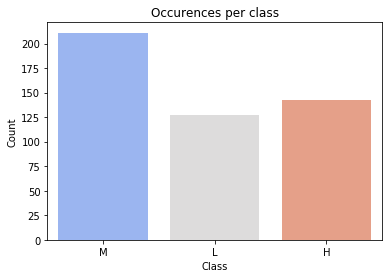

In [14]:
# Counts per class --> Is the dataset unbalanced?
counts = sns.countplot(x='Class', data=edm, palette='coolwarm')
counts.set(xlabel='Class', ylabel='Count', title='Occurences per class')
plt.show()

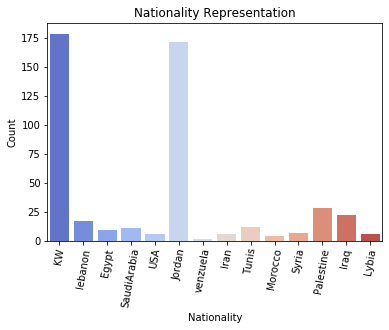

In [15]:
# Exploring nationalities
nat = sns.countplot(x='Nationality', data=edm, palette='coolwarm')
nat.set(xlabel='Nationality', ylabel='Count', title='Nationality Representation')
plt.setp(nat.get_xticklabels(), rotation=80)
plt.show()

The dataset is not extremely unbalanced. Although we do have a small dataset so this might still cause some problems with classification later on. Most of our students are from Kuwait or Jordan. This was already mentioned in the description of the dataset, but I thought it would be nice to provide a visual.

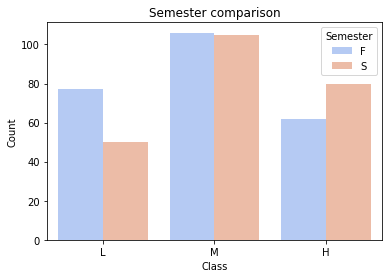

In [16]:
# Semester comparison
sem = sns.countplot(x='Class', hue='Semester', order=['L', 'M', 'H'], data=edm, palette='coolwarm')
sem.set(xlabel='Class', ylabel='Count', title='Semester comparison')
plt.show()

Mmh ... It looks like students's performed a bit better in the second semester ('S') than in the first semester ('F'). Suprisingly, the middle class stays the same but the lower class has less students in the second semester and the higher class has more students. Let's explore gender next.

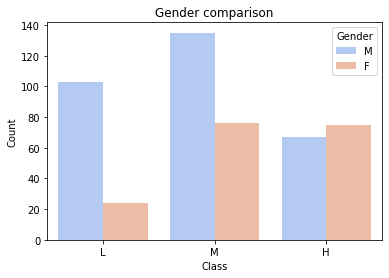

In [17]:
# gender comparison
plot = sns.countplot(x='Class', hue='Gender', data=edm, order=['L', 'M', 'H'], palette='coolwarm')
plot.set(xlabel='Class', ylabel='Count', title='Gender comparison')
plt.show()

It looks like women performed better than men on average. Would the amount of visited resources in the online environment influence the final grade?

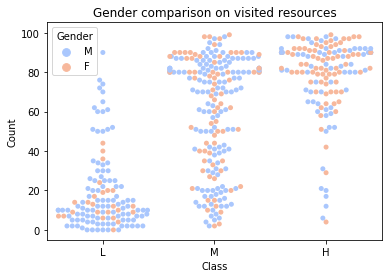

In [18]:
plot = sns.swarmplot(x='Class', y='VisitedResources', hue='Gender', order=['L', 'M', 'H'], 
              data=edm, palette='coolwarm')
plot.set(xlabel='Class', ylabel='Count', title='Gender comparison on visited resources')
plt.rcParams['figure.figsize']=(10,5)
plt.show()

This swarm plot shows us that students who received a lower grade (L) visited way fever resources than students that scored a M or H grade. Additionally, women who received a high mark (H) almost exclusively visited a lot of the online resources.

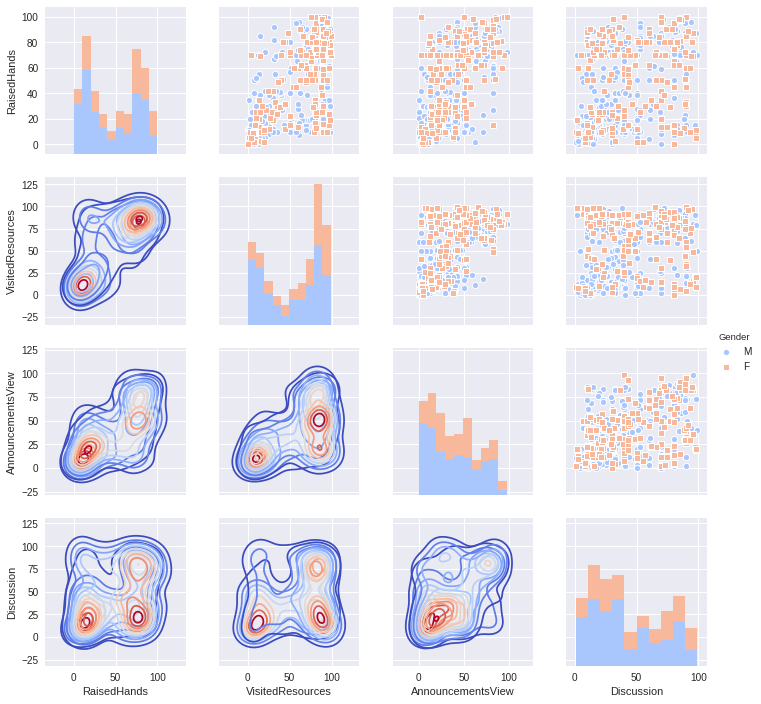

In [10]:
# Pairgrid, exploring our numerical variables and keeping the gender comparison
g = sns.PairGrid(edm, hue='Gender', palette='coolwarm', hue_kws={'marker': ['o', 's']})
g = g.map_diag(plt.hist)
g = g.map_upper(plt.scatter, linewidths=1, edgecolor='w', s=40)
g = g.map_lower(sns.kdeplot, lw=3, legend=False, cmap='coolwarm')
g = g.add_legend()

Pairgrid provides a clear way to explore our numerical data. The plot looks great, but it doesn't look like there are any specific relationships or patterns in the numerical data. However, when exploring the visited resources again we see that females generally visit more resources as shown in the histogram.

# Machine Learning

Now we get to the machine learning section. We will start by encoding our categorical variables and splitting the data into a train and test set.

In [11]:
X = edm.drop('Class', axis=1)
y = edm['Class']

# Encoding our categorical columns in X
labelEncoder = LabelEncoder()
cat_columns = X.dtypes.pipe(lambda x: x[x == 'object']).index
for col in cat_columns:
    X[col] = labelEncoder.fit_transform(X[col])

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

In [12]:
# Logistic Regression as baseline, then exploring tree-based methods

keys = []
scores = []
models = {'Logistic Regression': LogisticRegression(), 'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(n_estimators=300, random_state=52)}

for k,v in models.items():
    mod = v
    mod.fit(X_train, y_train)
    pred = mod.predict(X_test)
    print('Results for: ' + str(k) + '\n')
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    acc = accuracy_score(y_test, pred)
    print("accuracy is "+ str(acc)) 
    print('\n' + '\n')
    keys.append(k)
    scores.append(acc)
    table = pd.DataFrame({'model':keys, 'accuracy score':scores})

print(table)

Results for: Logistic Regression

[[37  1 14]
 [ 0 32  4]
 [ 8  7 41]]
             precision    recall  f1-score   support

          H       0.82      0.71      0.76        52
          L       0.80      0.89      0.84        36
          M       0.69      0.73      0.71        56

avg / total       0.77      0.76      0.76       144

accuracy is 0.763888888889



Results for: Decision Tree

[[32  0 20]
 [ 2 30  4]
 [12  4 40]]
             precision    recall  f1-score   support

          H       0.70      0.62      0.65        52
          L       0.88      0.83      0.86        36
          M       0.62      0.71      0.67        56

avg / total       0.71      0.71      0.71       144

accuracy is 0.708333333333



Results for: Random Forest

[[36  0 16]
 [ 0 31  5]
 [ 2  4 50]]
             precision    recall  f1-score   support

          H       0.95      0.69      0.80        52
          L       0.89      0.86      0.87        36
          M       0.70      0.89      0.79 

## Random Forest

The Random Forest Classifier performed best. Let's explore the number of estimators in the forest further. A general rule is that the RFC performs better when the amount of estimators increases.

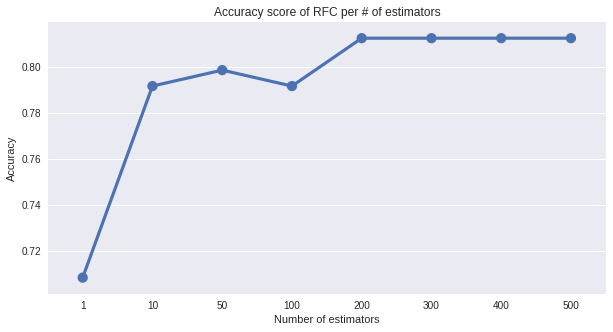

In [13]:
# Exploring the number of estimators in the random forest
score = []
est = []
estimators = [1, 10, 50, 100, 200, 300, 400, 500]
for e in estimators:
    rfc1 = RandomForestClassifier(n_estimators=e, random_state=52)
    pred1 = rfc1.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, pred1)
    score.append(accuracy)
    est.append(e)
plot = sns.pointplot(x=est, y=score)
plot.set(xlabel='Number of estimators', ylabel='Accuracy', 
         title='Accuracy score of RFC per # of estimators')
plt.show()

And indeed, the RFC performs better when the number of estimators increases. However, it plateaus at 200 estimators. In the for loop before I used 300 estimators which is a general number I like to start trying it out with. Apparently 200 estimators is enough for this dataset. If you start experimenting on a very large dataset, having less estimators will save you a lot of running time. 

We can also explore another variable like the minimum number of samples required to be at a leaf node.

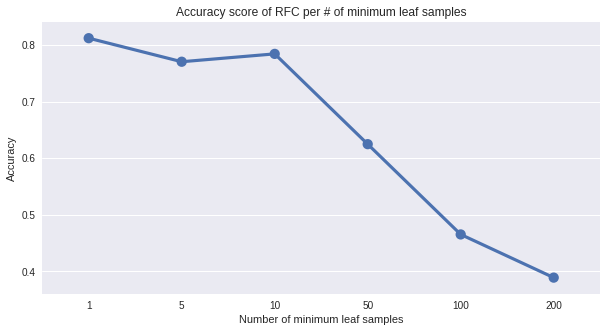

In [14]:
# Exploring minimum leaf samples
score = []
leaf = []
leaf_options = [1, 5, 10, 50, 100, 200]
for l in leaf_options:
    rfc2 = RandomForestClassifier(n_estimators=200, random_state=52, min_samples_leaf=l)
    pred2 = rfc2.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, pred2)
    score.append(accuracy)
    leaf.append(l)
plot = sns.pointplot(x=leaf, y=score)
plot.set(xlabel='Number of minimum leaf samples', ylabel='Accuracy', 
         title='Accuracy score of RFC per # of minimum leaf samples')
plt.show()

In this case we see that the accuracy score simply decreases as the minimum leaf samples increase. Therefore, it is best to keep this value at the default of 1.

## Extreme Gradient Boosting

Many Kaggle competitions have been won by using Extreme Gradient Boosting. I have never used it so let's give it a try. If you have any tips please share them in the comments.

In [15]:
xgb = XGBClassifier(seed=52)
pred = xgb.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("accuracy is "+ str(accuracy_score(y_test, pred)))      

[[38  0 14]
 [ 0 30  6]
 [ 4  5 47]]
             precision    recall  f1-score   support

          H       0.90      0.73      0.81        52
          L       0.86      0.83      0.85        36
          M       0.70      0.84      0.76        56

avg / total       0.81      0.80      0.80       144

accuracy is 0.798611111111


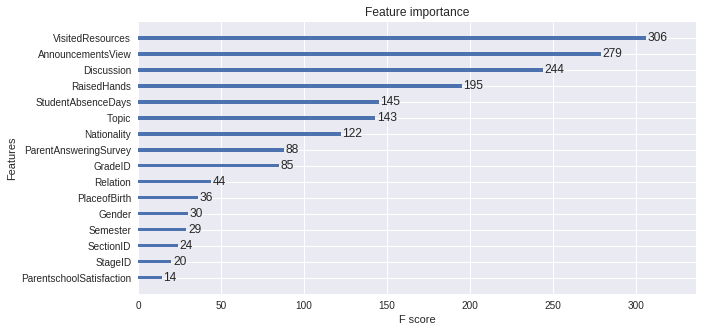

In [16]:
plot_importance(xgb)
plt.rcParams['figure.figsize']=(10,5)
plt.show()

the main feature in the XGB model is the number of visited resources. Earlier we saw that there was a big difference in visited resources between the L and M and H classes. Suprisingly, gender is very low on the feature importance list.

Next step is to try and improve the performance of our XGB Classifier by trying some different parameters and using a grid search approach.

In [17]:
# Let's try to improve the accuracy of the XGClassifier with a grid search approach.

d_values = []
l_values = []
n_values = []
acc_values = []
depth = [2, 3, 4]
learning_Rate = [0.01, 0.1, 1]
n_estimators = [50, 100, 150, 200]
for d in depth:
    for l in learning_Rate:
        for n in n_estimators:
            xgb = XGBClassifier(max_depth=d, learning_rate=l, n_estimators=n, seed=52)
            pred = xgb.fit(X_train, y_train).predict(X_test)
            acc = accuracy_score(y_test, pred)
            d_values.append(d)
            l_values.append(l)
            n_values.append(n)
            acc_values.append(acc)
            
dict = {'max_depth':d_values, 'learning_rate':l_values, 'n_estimators':n_values,
       'accuracy':acc_values}

output = pd.DataFrame.from_dict(data=dict)
print(output.sort_values(by='accuracy', ascending=False)) 
            

    accuracy  learning_rate  max_depth  n_estimators
29  0.819444           0.10          4           100
31  0.812500           0.10          4           200
16  0.805556           0.10          3            50
20  0.805556           1.00          3            50
27  0.805556           0.01          4           200
28  0.798611           0.10          4            50
19  0.798611           0.10          3           200
4   0.798611           0.10          2            50
23  0.798611           1.00          3           200
17  0.798611           0.10          3           100
30  0.798611           0.10          4           150
22  0.798611           1.00          3           150
14  0.798611           0.01          3           150
5   0.791667           0.10          2           100
13  0.791667           0.01          3           100
15  0.791667           0.01          3           200
21  0.784722           1.00          3           100
7   0.784722           0.10          2        

## Accuracy improved :)
We can see that using a learning_rate of 0.1, a max_depth of 4 and 100 estimators in our XGB classifier provides an accuracy of 0.8194. 

This is a nice improvement over our previous score of 0.7986

 The XGB model now also performs better than the random forest classifier which capped at 0.8125

Let's explore the important features in this 'best' model.

[[39  0 13]
 [ 0 32  4]
 [ 5  4 47]]
             precision    recall  f1-score   support

          H       0.89      0.75      0.81        52
          L       0.89      0.89      0.89        36
          M       0.73      0.84      0.78        56

avg / total       0.83      0.82      0.82       144

accuracy is 0.819444444444


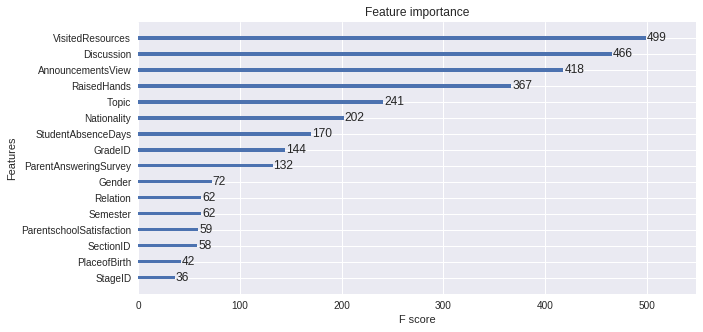

In [18]:
# Building the best XGB and looking at feature importances

xgb2 = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=100, seed=52)
pred = xgb2.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("accuracy is "+ str(accuracy_score(y_test, pred)))   

plot_importance(xgb2)
plt.rcParams['figure.figsize']=(10,5)
plt.show()

### Let's explore the feature importances of our best Random Forest model as well.

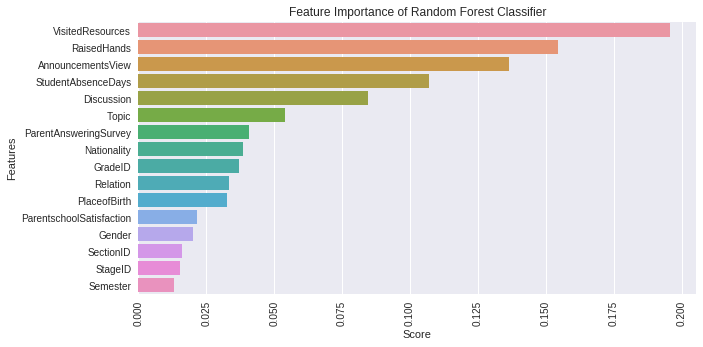

In [19]:
rfc = RandomForestClassifier(n_estimators=200, random_state=52)
pred = rfc.fit(X_train, y_train).predict(X_test)
dn = {'features':X.columns, 'score':rfc.feature_importances_}
df = pd.DataFrame.from_dict(data=dn).sort_values(by='score', ascending=False)
plot = sns.barplot(x='score', y='features', data=df, orient='h')
plot.set(xlabel='Score', ylabel='Features', 
         title='Feature Importance of Random Forest Classifier')
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

Visited resources is the most important feature in both the XGB and the RFC model. However, many differences can be observed for the other features. Discussion, for example, is almost the most important feature in the XGB model but is much less important in the RFC model.